特征工程：将数据转换为能更好的表示潜在问题的特征，从而提高机器学习性能<p>
特征构造目的：增强数据表达，添加先验知识<p>
1.统计量特征：计数，求和，比例，标准差<p>
2.时间特征：绝对时间，相对时间，节假日，双休日<p>
3.地理信息：分桶<p>
4.非线性变换：去log/平方/根号<p>
5.数据分桶：等频/等距分桶/卡方分桶<p>
6.特征组合

特征选择的目的：降低噪声，平滑预测能力和计算复杂度，增强模型预测性能<p>
过滤式<p>
包裹式<p>
嵌入式<p>

# 2.1 导入数据分析库

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

# 2.2 读取数据

In [104]:
train_data= pd.read_csv('used_car_train_20200313.csv',sep=' ')
test_data= pd.read_csv('used_car_testA_20200313.csv',sep=' ')
train_data.shape,test_data.shape

((150000, 31), (50000, 30))

## 2.3 离群点检测

In [105]:
def box_plot_outliers(data_ser,box_scale):
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up  = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up  = (data_ser > val_up)
        return(rule_low,rule_up),(val_low,val_up)

In [106]:
train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

Delete number is:963
new column number is:149037
Description of data less than lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


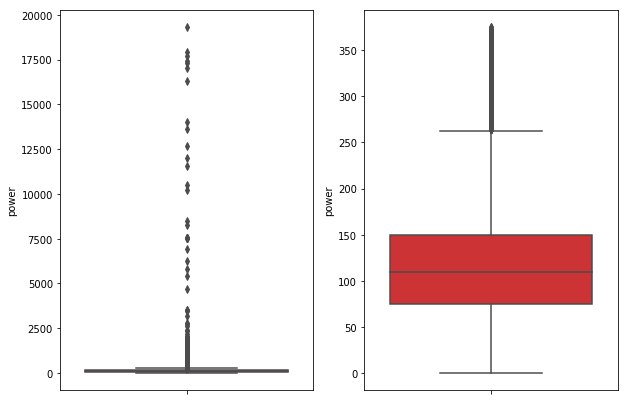

In [107]:
data = train_data.copy()
data_series = data['power']
rule,value = box_plot_outliers(data_series,box_scale = 3)
index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
print('Delete number is:{}'.format(len(index)))
data = data.drop(index)
data.reset_index(drop = True, inplace = True)
print('new column number is:{}'.format(data.shape[0]))
index_low = np.arange(data_series.shape[0])[rule[0]]
outliers = data_series.iloc[index_low]
print('Description of data less than lower bound is:')
print(pd.Series(outliers).describe())
index_up = np.arange(data_series.shape[0])[rule[1]]
outliers = data_series.iloc[index_up]
print("Description of data larger than the upper bound is:")
print(pd.Series(outliers).describe())
    
fig,ax = plt.subplots(1,2,figsize = (10,7))
sns.boxplot(y = train_data['power'],data = train_data,palette = 'Set1',ax = ax[0])
sns.boxplot(y = data['power'],data = data,palette = 'Set1',ax = ax[1])


In [108]:
data.shape

(149037, 31)

In [109]:
outliers

77          500
171         387
221         740
534        7515
632         396
751         431
882         424
919        1398
1080        420
1283        431
1331        385
1337        564
1437        450
2002        400
2088        480
2187        555
2526        400
2671        555
2917        560
3161        457
3417        400
4077        601
4271        500
4297        404
4398       1771
4428        450
4790       1598
4930        396
5179       1653
5371        387
          ...  
146036      387
146222      457
146245     1151
146277      600
146365      400
146678      416
147519      400
147691      400
147891      387
148030      776
148049      450
148197      525
148246     2598
148365    17700
148439      504
148456      436
148554      426
148665    19312
148701      450
148751      476
148771      525
148824      435
148969      481
149039      387
149251      680
149414      450
149586      457
149644      549
149927      450
149955      585
Name: power, Length: 963

## 2.4 对训练集测试集进行特征构造

In [110]:
train_data['train']=1
test_data['test']=0
data_all=pd.concat([train_data,test_data],ignore_index=True)

### 2.4.1 构造车辆使用时间used_time

In [111]:
data_all['used_time'] = (pd.to_datetime(data_all['creatDate'],format = '%Y%m%d',errors = 'coerce') -pd.to_datetime(data_all['regDate'],format = '%Y%m%d',errors = 'coerce')).dt.days
data_all.head()

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,...,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,...,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,4385.0
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,...,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,4757.0
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,...,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,4382.0
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,...,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,7125.0
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,...,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,1531.0


In [112]:
data_all['used_time'].isnull().sum()

15101

### 2.4.2 构造城市特征city

In [113]:
data_all['city'] = data_all['regionCode'].apply(lambda x : str(x)[:-3])
data_all = data_all.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [114]:
data_all.columns

Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'kilometer',
       'model', 'name', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'test', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'used_time', 'city'],
      dtype='object')

### 2.4.3 对偏移特征power进行log变换，最大最小值归一化

(array([1.99946e+05, 1.70000e+01, 4.00000e+00, 1.10000e+01, 2.00000e+00,
        5.00000e+00, 4.00000e+00, 3.00000e+00, 6.00000e+00, 2.00000e+00]),
 array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000., 20000.]),
 <a list of 10 Patch objects>)

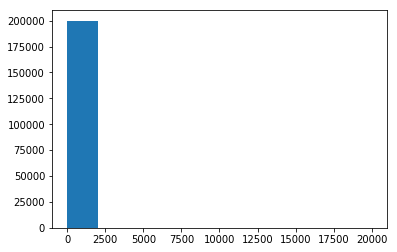

In [115]:
plt.hist(data_all['power'])

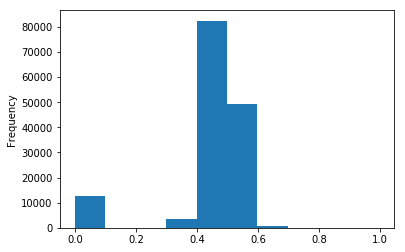

In [116]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_all['power'] = np.log(data_all['power'] + 1) 
data['power'] = ((data_all['power'] - np.min(data_all['power'])) / (np.max(data_all['power']) - np.min(data_all['power'])))
data['power'].plot.hist()

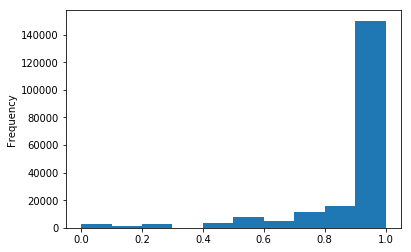

In [117]:
data_all['kilometer'] = np.log(data_all['kilometer'] + 1) 
data_all['kilometer'] = ((data_all['kilometer'] - np.min(data_all['kilometer'])) / (np.max(data_all['kilometer']) - np.min(data_all['kilometer'])))
data_all['kilometer'].plot.hist()

In [119]:
data_all = pd.get_dummies(data_all, columns=['model', 'brand', 'bodyType', 'fuelType','gearbox', 'notRepairedDamage','notRepairedDamage'])
data_all.shape

(200000, 337)

In [120]:
data_all.columns

Index(['SaleID', 'kilometer', 'name', 'offerType', 'power', 'price', 'seller',
       'test', 'train', 'v_0',
       ...
       'fuelType_5.0', 'fuelType_6.0', 'gearbox_0.0', 'gearbox_1.0',
       'notRepairedDamage_-', 'notRepairedDamage_0.0', 'notRepairedDamage_1.0',
       'notRepairedDamage_-', 'notRepairedDamage_0.0',
       'notRepairedDamage_1.0'],
      dtype='object', length=337)

In [124]:
cor_features= ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14','price' ]
correlation = data_all[cor_features].corr()
print(correlation['price'].sort_values(ascending = False),'\n')

price        1.000000
v_12         0.692823
v_8          0.685798
v_0          0.628397
power        0.284326
v_5          0.164317
v_2          0.085322
v_6          0.068970
v_1          0.060914
v_14         0.035911
v_13        -0.013993
v_7         -0.053024
v_4         -0.147085
v_9         -0.206205
v_10        -0.246175
v_11        -0.275320
kilometer   -0.399744
v_3         -0.730946
Name: price, dtype: float64 



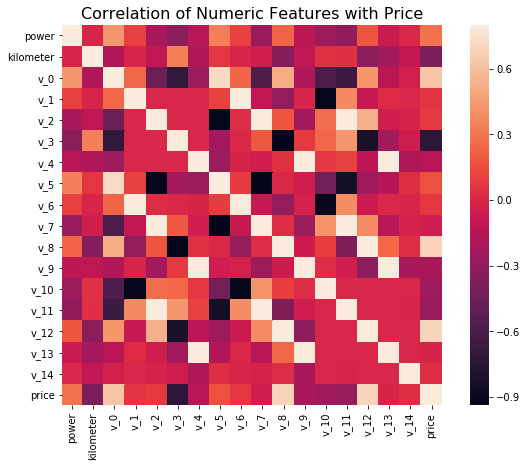

In [126]:
f,ax = plt.subplots(figsize = (10, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)